In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from celldisect import CellDISECT
from scvi.model.base import BaseModelClass
import rapids_singlecell as rsc

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [3]:
adata = sc.read_h5ad('../eraslan_preprocessed1212_split_deg.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

3370.0

In [5]:
adata.X.max()

9.210441

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']
pre_path = '../models/ablation_dis2p_cfW_betterModelSize/'
model_paths = []
for model_path in os.listdir(pre_path):
    model_paths.append(model_path)

In [8]:
model_paths

['dis2p_cE_split_2_cfW_0.08',
 'dis2p_cE_split_2_cfW_0.0',
 'dis2p_cE_split_2_cfW_5.0',
 'dis2p_cE_split_2_cfW_0.05',
 'dis2p_cE_split_2_cfW_0.8',
 'dis2p_cE_split_2_cfW_0.03',
 'dis2p_cE_split_2_cfW_0.3',
 'dis2p_cE_split_2_cfW_10.0',
 'dis2p_cE_split_2_cfW_0.005',
 'dis2p_cE_split_2_cfW_0.01',
 'dis2p_cE_split_2_cfW_0.5',
 'dis2p_cE_split_2_cfW_0.1',
 'dis2p_cE_split_2_cfW_1.0']

In [9]:
names = [name.split('_')[-1] for name in model_paths]

In [10]:
models = {}
for i, model_path in enumerate(model_paths):
    models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)

INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_0.08/model.pt already downloaded  


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_0.0/model.pt already downloaded   
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_5.0/model.pt already downloaded   
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_0.05/model.pt already downloaded  
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_0.8/model.pt already downloaded   
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_0.03/model.pt already downloaded  
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_0.3/model.pt already downloaded   
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_10.0/model.pt already downloaded  
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_split_2_cfW_0.005/model.pt already downloaded 
INFO     File ../models/ablation_dis2p_cfW_betterModelSize//dis2p_cE_spl

In [11]:
models = dict(sorted(models.items(), key=lambda t: float(t[0])))

In [12]:
def pred_our_ood_avg(model,
                adata,  # OOD Adata
                cov_names,
                cov_values: str,
                cov_values_cf: str,
                cats: list[str],
                n_samples_from_source = None,
                n_samples: int = 1000,
                dec_b=0,
                dec_e=None):
    adata.X = adata.layers['counts'].copy()
    adata.obs['idx'] = [i for i in range(len(adata))]

    true_indices = pd.DataFrame([adata.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    true_idx = list(adata[true_indices].obs['idx'])
    
    source_indices = pd.DataFrame([adata.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_idx = list(adata[source_indices].obs['idx'])

    true_adata = adata[adata.obs['idx'].isin(true_idx)].copy()
    source_adata = adata[adata.obs['idx'].isin(source_idx)].copy()

    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(source_adata)), n_samples_from_source)
        source_adata = source_adata[chosen_ids].copy()
    adata_cf = source_adata.copy()
        
    
    for i, cov_name in enumerate(cov_names):
        adata_cf.obs.loc[:, cov_name] = pd.Categorical(
            [cov_values_cf[i] for _ in adata_cf.obs[cov_name]])
    batch_size = len(adata_cf)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.setup_anndata(
        adata_cf,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    adata_cf = model._validate_anndata(adata_cf)
    source_adata = model._validate_anndata(source_adata)
    # print("Data loader OOD")
    scdl_cf = model._make_data_loader(
        adata=adata_cf, batch_size=batch_size
    )
    scdl = model._make_data_loader(
        adata=source_adata, batch_size=batch_size
    )
    # cov_idx = cats.index(cov_name)
    px_cf_mean_list = []
    for tensors, tensors_cf in zip(scdl, scdl_cf):
        x, pxs_cf = model.module.sub_forward_cf_avg(
                            x=tensors[REGISTRY_KEYS.X_KEY].to(device),
                            cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device),
                            cat_covs_cf=tensors_cf[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

        # for px_cf in pxs_cf:
        #     samples = []
        #     if px_cf is None:
        #         continue
        #     for _ in range(n_samples):
        #         samples.append(px_cf.sample().to('cpu'))
        #     samples = torch.stack(samples, dim=0)
        #     x_cf = torch.mean(samples, dim=0)
        #     print(samples.shape)
        #     print(x_cf.shape)
        #     px_cf_mean_list.append(x_cf)
        for px_cf in pxs_cf[dec_b: dec_e]:
            if px_cf is None:
                continue
            x_cf = px_cf.mu
            px_cf_mean_list.append(x_cf)
    if len(px_cf_mean_list) > 1:
        px_cf_mean_tensor = torch.stack(px_cf_mean_list, dim=0)
        px_cf_mean_pred = torch.mean(px_cf_mean_tensor, dim=0)
    else:
        px_cf_mean_tensor = px_cf_mean_list[0][None, :, :]
        px_cf_mean_pred = px_cf_mean_list[0]
    

    px_cf_mean_pred = px_cf_mean_pred.to('cpu').detach().numpy()
    px_cf_mean_tensor = px_cf_mean_tensor.to('cpu').detach().numpy()

    px_cf_mean_tensor = ad.AnnData(px_cf_mean_pred)
    px_cf_mean_tensor = torch.tensor(px_cf_mean_tensor.X)

    true_x_count = torch.tensor(true_adata.X.toarray())
    cf_x_count = torch.tensor(source_adata.X.toarray())

    x_true = true_x_count
    x_pred = px_cf_mean_tensor
    x_ctrl = cf_x_count

    x_true = np.log1p(x_true)
    x_pred = np.log1p(x_pred)
    x_ctrl = np.log1p(x_ctrl)
    return x_ctrl, x_true, x_pred, px_cf_mean_tensor, true_x_count

In [13]:
cell_type_to_check = 'Epithelial cell (luminal)'

cov_names = ['sex', 'tissue']
cov_values = ['female', 'breast']
cov_values_cf = ['male', 'prostate gland']

In [14]:
preds = {}
for name, model in models.items():
    x_ctrl, x_true, x_pred, _, _ = pred_our_ood_avg(model,
                                              adata[adata.obs['Broad cell type'] == cell_type_to_check].copy(),
                                              cov_names=cov_names,
                                              cov_values=cov_values,
                                              cov_values_cf=cov_values_cf,
                                              cats=cats,
                                              n_samples_from_source=None,
                                              dec_b=0,
                                              dec_e=None,
                                             )
    preds[name] = x_pred

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer set

In [15]:
deg_list = adata.uns['rank_genes_groups_split_2']['male_prostate gland']

r2_results = {}
for n_top_deg in [10, 20, 40, 50, 100, 150, 200, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_degs = [pred[:, degs] for pred in preds.values()]

    r2_means = [pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0)) for x_pred_deg in x_degs]
    
    r2_vars = [pearsonr(x_true_deg.var(0), x_pred_deg.var(0)) for x_pred_deg in x_degs]
    
    r2_results[str(n_top_deg)] = {}
    for i, name in enumerate(preds.keys()):
        r2_results[str(n_top_deg)][name] = r2_means[i][0]
        # r2_results[str(n_top_deg)][name + '_var'] = r2_vars[i][0]

r2_results = pd.DataFrame.from_dict(r2_results).T

# #######################################################################
# r2_results_subtract = {}
# for n_top_deg in [10, 20, 40, 50, 100, 150, 200, None]:
#     if n_top_deg is not None:
#         degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
#     else:
#         degs = np.arange(adata.n_vars)
#         n_top_deg = 'all'

#     x_true_deg = x_true[:, degs]
#     x_pred_deg = x_pred[:, degs]
#     x_ctrl_deg = x_ctrl[:, degs]
#     x_biolord_deg = x_biolord[:, degs]
#     x_scdisinfact_deg = x_scdisinfact[:, degs]
    

#     r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
#     r2_mean_biolord_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_biolord_deg.mean(0) - x_ctrl_deg.mean(0))
#     r2_mean_scdisinfact_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_scdisinfact_deg.mean(0) - x_ctrl_deg.mean(0))
    
#     r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
#     r2_var_biolord_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_biolord_deg.var(0) - x_ctrl_deg.var(0))
#     r2_var_scdisinfact_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_scdisinfact_deg.var(0) - x_ctrl_deg.var(0))
    
#     r2_results_subtract[str(n_top_deg)] = {}
#     r2_results_subtract[str(n_top_deg)]['Prediction'] = r2_mean_deg[0]
#     r2_results_subtract[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg[0]
#     r2_results_subtract[str(n_top_deg)]['scdisinfact'] = r2_mean_scdisinfact_deg[0]

#     r2_results_subtract[str(n_top_deg)]['Prediction_var'] = r2_var_deg[0]
#     r2_results_subtract[str(n_top_deg)]['Biolord_var'] = r2_var_biolord_deg[0]
#     r2_results_subtract[str(n_top_deg)]['scdisinfact_var'] = r2_var_scdisinfact_deg[0]
    
# r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T

In [16]:
# preds.keys()
r2_results

,0.0,0.005,0.01,0.03,0.05,0.08,0.1,0.3,0.5,0.8,1.0,5.0,10.0
10,0.965114,0.965096,0.965942,0.965666,0.965000,0.962896,0.962499,0.961060,0.957947,0.945391,0.934805,0.596144,0.208549
20,0.928810,0.927050,0.928414,0.929074,0.927496,0.927012,0.927198,0.928828,0.925577,0.897018,0.882792,0.594521,0.301981
40,0.863087,0.866509,0.862324,0.863351,0.869320,0.868775,0.869708,0.872896,0.871157,0.854991,0.841672,0.466957,0.306850
50,0.834183,0.836557,0.832464,0.834347,0.839544,0.839163,0.840251,0.846784,0.844782,0.833596,0.825224,0.474146,0.325916
100,0.582607,0.574798,0.572866,0.579172,0.570767,0.565823,0.566227,0.579617,0.582222,0.531085,0.521381,0.349361,0.330994
150,0.489629,0.484796,0.482295,0.486647,0.482666,0.480770,0.481164,0.488482,0.490218,0.470815,0.468120,0.341822,0.323052
200,0.364824,0.358244,0.359266,0.363228,0.358108,0.356578,0.358173,0.371274,0.370364,0.338082,0.333022,0.261959,0.259013
all,0.522083,0.513921,0.517413,0.519186,0.512273,0.511621,0.511470,0.512694,0.503558,0.500646,0.507822,0.535924,0.474787


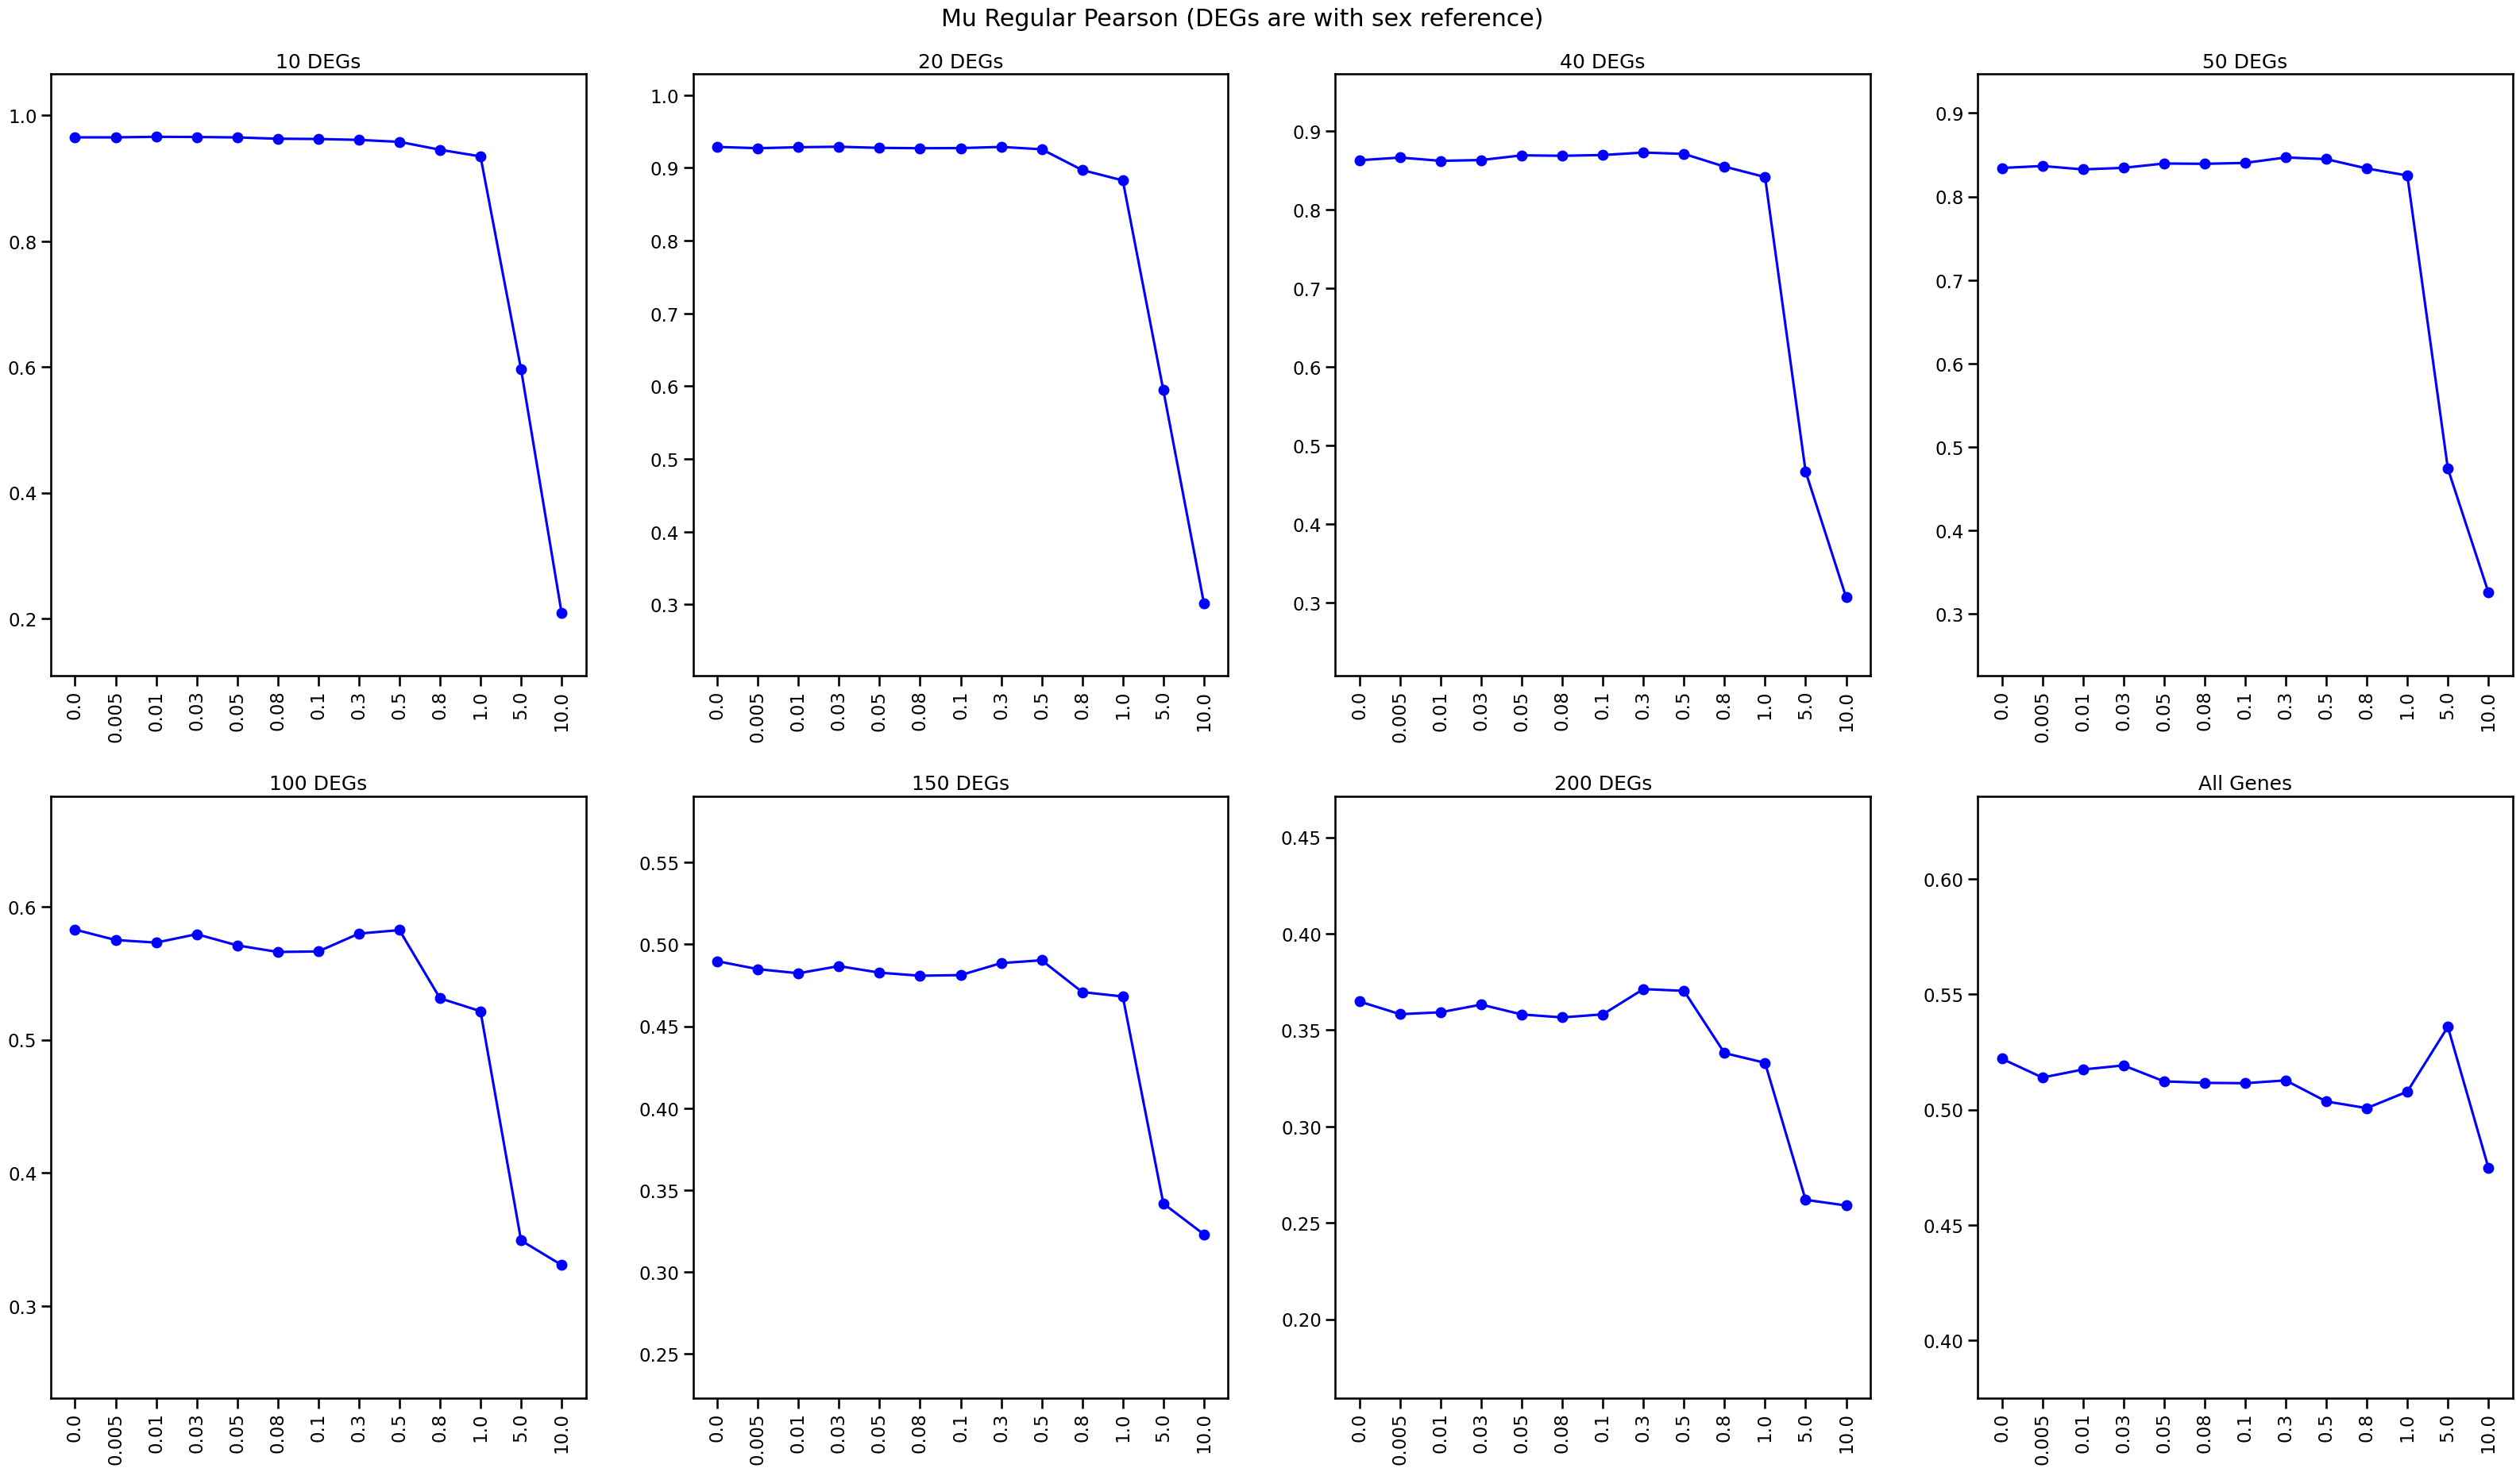

In [17]:
n_rows = r2_results.shape[0]
df = r2_results

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 12))

for i in range(n_rows):
    row = df.iloc[i]
    ax = axes[i // 4, i % 4] 
    
    # Line plot instead of bar plot
    ax.plot(range(len(row)), row, marker='o', linestyle='-', color='blue')

    ax.axhline(y=0, color='black', linestyle='--')  # Baseline

    # Value labels above the points (adjust 'y' for vertical position)
    # for x, y in enumerate(row):
        # ax.text(x, y + 0.05, f'{y:.4f}', ha='center', va='bottom', fontsize=15)  

    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(df.columns, rotation=90)
    ax.set_ylim(row.min() - 0.1, row.max() + 0.1)  

    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')

fig.suptitle('Mu Regular Pearson (DEGs are with sex reference)', y = 1.57)
plt.subplots_adjust(top=1.5)
plt.show()


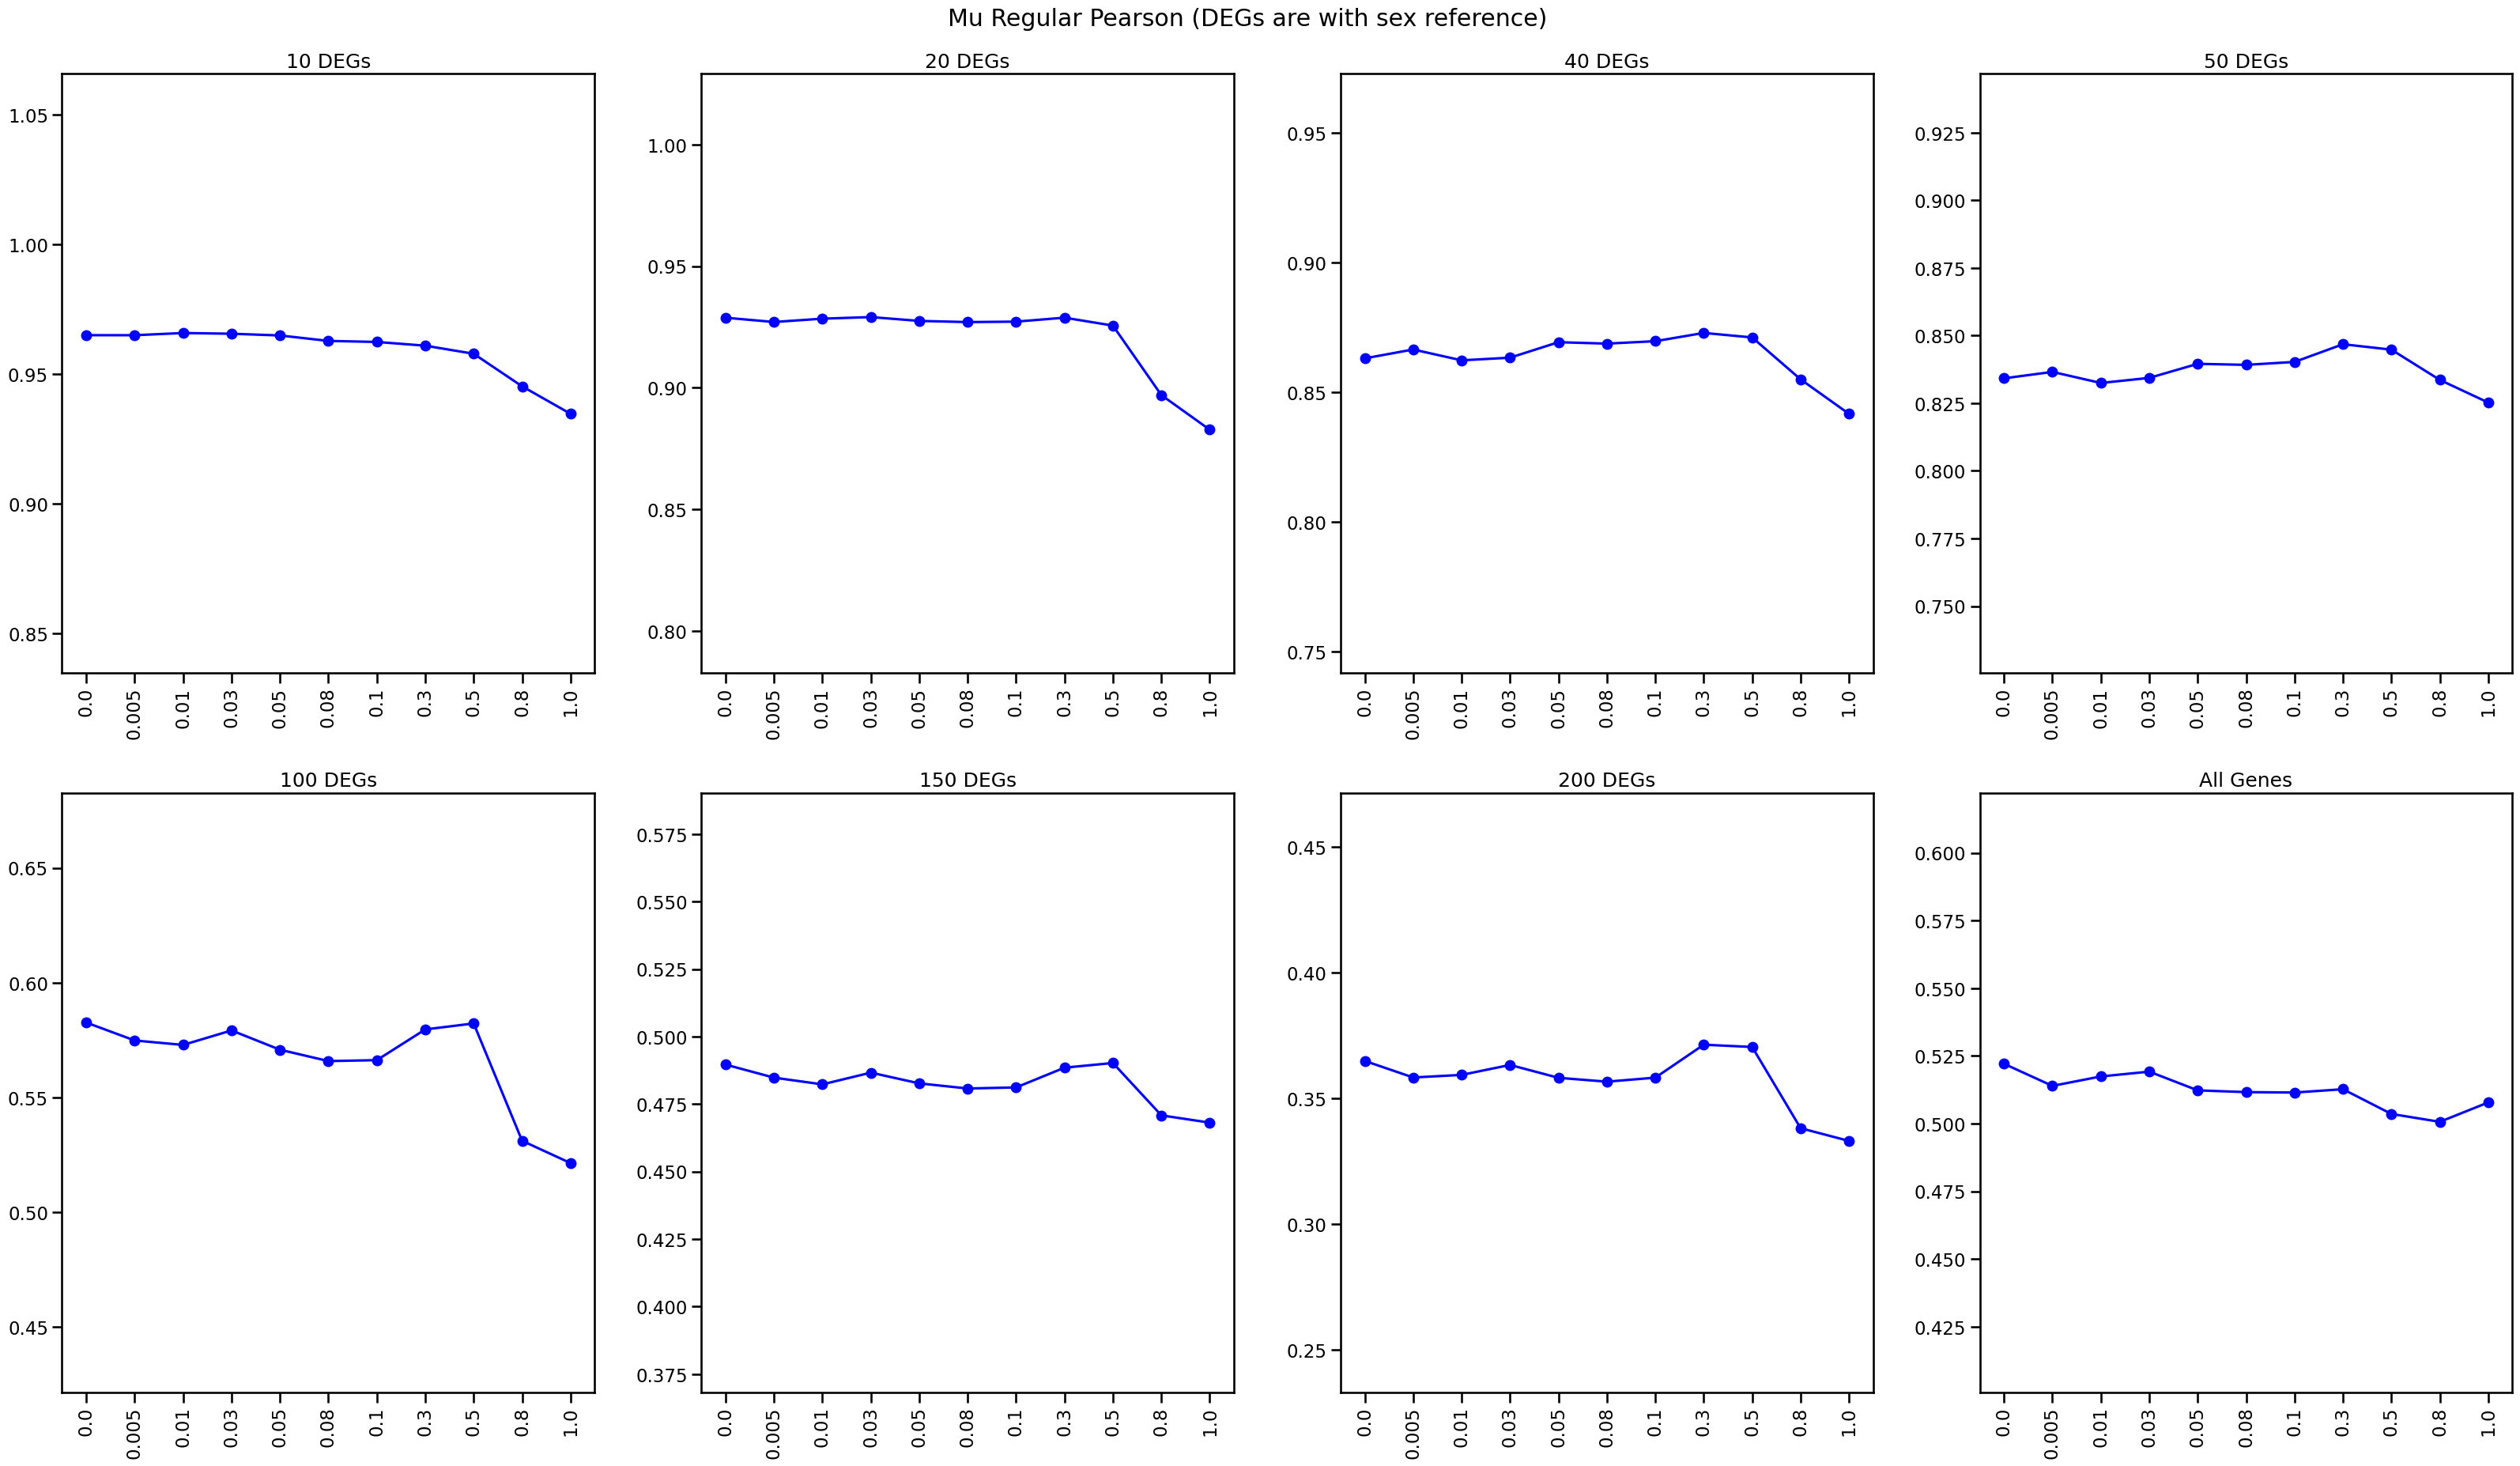

In [24]:
n_rows = r2_results.shape[0]
df = r2_results

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 12))

for i in range(n_rows):
    row = df.iloc[i, :-2]
    ax = axes[i // 4, i % 4] 
    
    # Line plot instead of bar plot
    ax.plot(range(len(row)), row, marker='o', linestyle='-', color='blue')

    ax.axhline(y=0, color='black', linestyle='--')  # Baseline

    # Value labels above the points (adjust 'y' for vertical position)
    # for x, y in enumerate(row):
        # ax.text(x, y + 0.05, f'{y:.4f}', ha='center', va='bottom', fontsize=15)  

    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(df.columns[:-2], rotation=90)
    ax.set_ylim(row.min() - 0.1, row.max() + 0.1)  

    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')

fig.suptitle('Mu Regular Pearson (DEGs are with sex reference)', y = 1.57)
plt.subplots_adjust(top=1.5)
plt.show()
